In [297]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [298]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [299]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
experiment = "Tonsil"
cores=['DonorA', 'DonorE']
# cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4', 'F7']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]
# datasets = ['E6_1', 'E6_2', 'E6_3']

# Load data

In [301]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [302]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [303]:
adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_IMC.merge(df_intensity_TS, on="Id")
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=5)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset DonorA_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_7364/4195016790.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_3
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_4
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_5
normalizing counts per cell
    finished (0:00:00)
DonorA_6 cannot be read
Sucessfully read dataset DonorE_1
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_2
normalizing counts per cell
    finished ({time_passed})
Sucessfully read dataset DonorE_3
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_4
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_5
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_6
normalizing counts per cell
    finished (0:00:00)


In [304]:
IMC_markers = df_intensity_IMC.columns[1:]
SIMS_masses = df_intensity_TS.columns[1:]

## Get literature lut

In [305]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_05052022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.5
matched_dfs = []
for mz in SIMS_masses.astype(float):
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
        
matched = pd.concat(matched_dfs)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [306]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 43


In [307]:
# Selected channel
all_markers = IMC_markers.append(SIMS_masses_subset)
all_markers_name = IMC_markers.append(SIMS_nm_subset)

# Get SIMS data
adata_all = adata.copy()
adata = adata[:, all_markers]
adata.var_names = all_markers_name
sc.pp.scale(adata)
df_SIMS = pd.DataFrame(adata_SIMS.X, columns=all_markers_name)

In [321]:
SIMS_masses = SIMS_nm_subset

# Calculate correlation between IMC markers intensity with SIMS channels

In [322]:
from sklearn.preprocessing import LabelEncoder
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [323]:
# Get correlation matrix
df = pd.DataFrame(adata.X, columns=adata.var_names.tolist())
df_corr = df.corr()

In [324]:
n = 10
marker = 'Ki67'
n_cut = 100

# Get positive and negative correlation
corr_pos = df_corr.loc[marker].nlargest(25).index.tolist()
corr_neg = df_corr.loc[marker].nsmallest(25).index.tolist()

# Get only SIMS masses
corr_pos = [corr for corr in corr_pos if corr in SIMS_masses][:n]
corr_neg = [corr for corr in corr_neg if corr in SIMS_masses][:n]
corr_list = [marker] + corr_pos + corr_neg

# Get range 
df_intensity = df[corr_list]
df_intensity.sort_values(by=[marker], inplace=True)
df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop') 

LE = LabelEncoder()
df_intensity[f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\thu71\AppData\Local\Temp/ipykernel_7364/1082389263.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop')
C:\Users\thu71\AppData\Local\Temp/ipykernel_7364/1082389263.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [325]:
df_sort = df_intensity.groupby('Ki67 cut').mean()

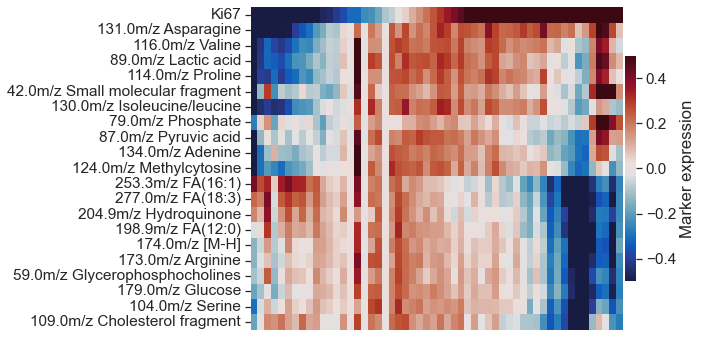

In [331]:
with sns.plotting_context('notebook', font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.heatmap(df_sort.T, ax=ax, cmap=heatmap_cmp,
                     xticklabels=False, yticklabels=True, 
                     cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7}, 
                     vmin=-0.5, vmax=0.5)
    ax.set(xlabel='')
    plt.tight_layout()
    plt.show()

# Protein marker line plot

In [332]:
df_cd20 = df[df.CD20>1]
df_cd21 = df[df.CD21>1]
df_cd38_cd27 = df[(df.CD27>1)&(df.CD38>1)]
df_cd38 = df[(df.CD27<1)&(df.CD38>1)]
df_cd27 = df[(df.CD27>1)&(df.CD38<1)]
df_naive = df[(df.CD27<1)&(df.CD38<1)&(df.CD20>1)]

dfs = [df_cd20, df_cd21, df_cd38_cd27, df_cd38, df_cd27, df_naive]
names = ['CD20+', 'CD21+', 'CD38+CD27+', 'CD38+CD27-', 'CD38-CD27+', 'CD38-CD27-CD20+']

In [333]:
from collections import defaultdict

counts = defaultdict(list)

for i, df_marker in enumerate(dfs):
    total = len(df_marker)
    ki67 = len(df_marker[df_marker.Ki67 > 1])
    counts['Name'].append(names[i])
    counts['Total'].append(total)
    counts['Ki67+ Cell'].append(ki67)
    counts['Ki67+ Fraction'].append(ki67/total)

In [334]:
df = pd.DataFrame(counts)

In [335]:
df

,Name,Total,Ki67+ Cell,Ki67+ Fraction
0,CD20+,3936,1003,0.254827
1,CD21+,5118,1185,0.231536
2,CD38+CD27+,1038,283,0.272640
3,CD38+CD27-,3792,891,0.234968
4,CD38-CD27+,3439,258,0.075022
5,CD38-CD27-CD20+,1947,385,0.197740


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'CD20+'),
  Text(1, 0, 'CD21+'),
  Text(2, 0, 'CD38+CD27+'),
  Text(3, 0, 'CD38+CD27-'),
  Text(4, 0, 'CD38-CD27+'),
  Text(5, 0, 'CD38-CD27-CD20+')])

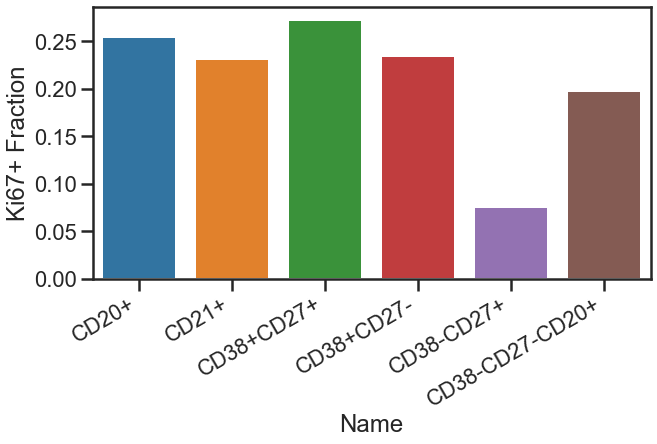

In [336]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x="Name", y="Ki67+ Fraction", data=df)
plt.xticks(rotation=30, ha='right')

# Protein Marker corr

In [337]:
df = pd.DataFrame(adata.X, columns=adata.var_names.tolist())

df_positif =  df.loc[:, IMC_markers]
df_corr = df_positif.corr()



In [338]:
n = 10
marker = 'Ki67'
n_cut = 50

corr_list = df_corr.loc[marker].nlargest(25).index.tolist()

# # Get positive and negative correlation
# corr_pos = df_corr.loc[marker].nlargest(25).index.tolist()
# corr_neg = df_corr.loc[marker].nsmallest(25).index.tolist()

# # Get only SIMS masses
# corr_pos = [corr for corr in corr_pos if corr in SIMS_masses][:n]
# corr_neg = [corr for corr in corr_neg if corr in SIMS_masses][:n]
# corr_list = [marker] + corr_pos + corr_neg

# Get range 
df_intensity = df[corr_list]
df_intensity.sort_values(by=[marker], inplace=True)
df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop') 

LE = LabelEncoder()
df_intensity[f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\thu71\AppData\Local\Temp/ipykernel_7364/2978414539.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop')
C:\Users\thu71\AppData\Local\Temp/ipykernel_7364/2978414539.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [339]:
df_sort = df_intensity.groupby('Ki67 cut').mean()

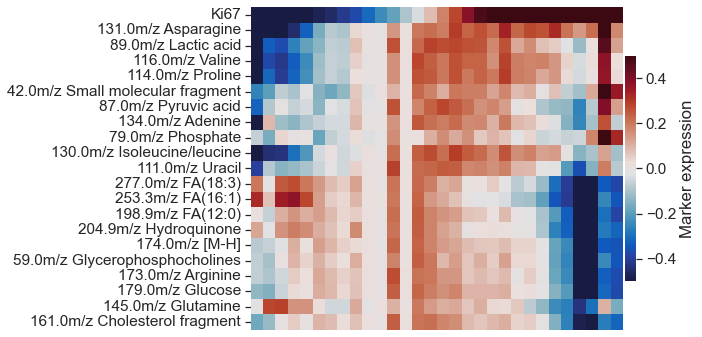

In [340]:
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.heatmap(df_sort.T, ax=ax, cmap=heatmap_cmp,
                 xticklabels=False, yticklabels=True, 
                 cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7}, 
                 vmin=-0.5, vmax=0.5)
ax.set(xlabel='')
plt.tight_layout()
plt.show()

# Specific cell type

In [359]:
df = pd.DataFrame(adata.X, columns=adata.var_names.tolist())

df_positif =  df[(df.CD21>1)]
df_corr = df_positif.corr()



In [360]:
n = 10
marker = 'Ki67'
n_cut = 50

# Get positive and negative correlation
corr_pos = df_corr.loc[marker].nlargest(25).index.tolist()
corr_neg = df_corr.loc[marker].nsmallest(25).index.tolist()

# Get only SIMS masses
corr_pos = [corr for corr in corr_pos if corr in SIMS_masses][:n]
corr_neg = [corr for corr in corr_neg if corr in SIMS_masses][:n]
corr_list = [marker] + corr_pos + corr_neg

# Get range 
df_intensity = df[corr_list]
df_intensity.sort_values(by=[marker], inplace=True)
df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop') 

LE = LabelEncoder()
df_intensity[f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])

C:\Users\thu71\AppData\Local\Temp/ipykernel_7364/2001504780.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop')
C:\Users\thu71\AppData\Local\Temp/ipykernel_7364/2001504780.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity[f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])


In [361]:
df_sort = df_intensity.groupby('Ki67 cut').mean()

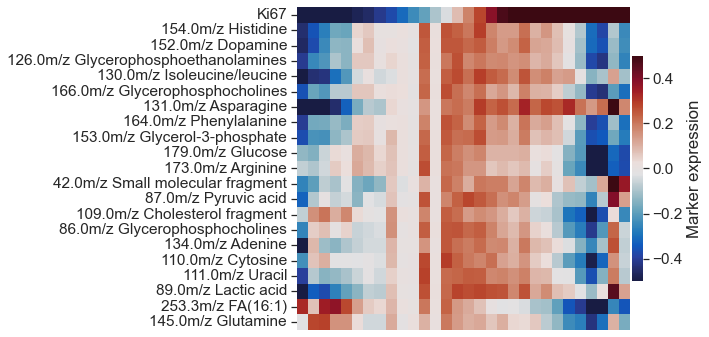

In [362]:
with sns.plotting_context('notebook', font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.heatmap(df_sort.T, ax=ax, cmap=heatmap_cmp,
                     xticklabels=False, yticklabels=True, 
                     cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7}, 
                     vmin=-0.5, vmax=0.5)
    ax.set(xlabel='')
    plt.tight_layout()
    plt.show()